# Full Competition Submission

The competition can be found at: https://www.kaggle.com/c/house-prices-advanced-regression-techniques

## Setup

In [3]:
# Imports

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from scipy.special import boxcox1p
from scipy.stats import norm, skew 
from sklearn import linear_model
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import LabelEncoder, RobustScaler, StandardScaler
import lightgbm as lgb
import xgboost as xgb

import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn

import os

In [4]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

# Save the ID column for future use
train_ID = train['Id']
test_ID = test['Id']

# Drop the ID column
train = train.drop("Id", axis = 1)
test = test.drop("Id", axis = 1)

In [5]:
# Set the number of folds for cross validation
n_folds = 5
# Define a scoring Function
def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(train.values)
    rmse= np.sqrt(-cross_val_score(model, train.values, y_train, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

## Preprocessing

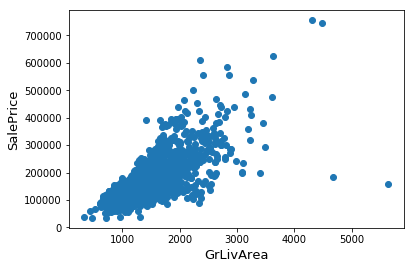

In [6]:
fig, ax = plt.subplots()
ax.scatter(x = train['GrLivArea'], y = train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.show()

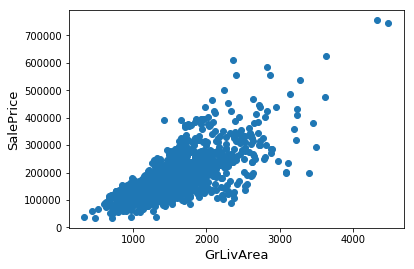

In [7]:
#Deleting outliers
train = train.drop(train[(train['GrLivArea']>4000) & (train['SalePrice']<300000)].index)

#Check the graphic again
fig, ax = plt.subplots()
ax.scatter(train['GrLivArea'], train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.show()


 mu = 180932.92 and sigma = 79467.79



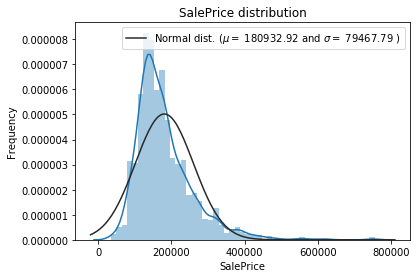

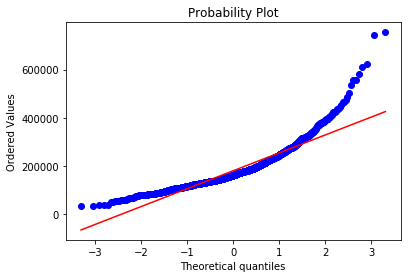

In [8]:
sns.distplot(train['SalePrice'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(train['SalePrice'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(train['SalePrice'], plot=plt)
plt.show()


 mu = 12.02 and sigma = 0.40



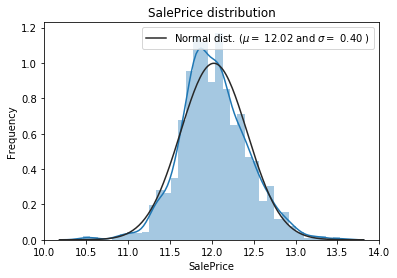

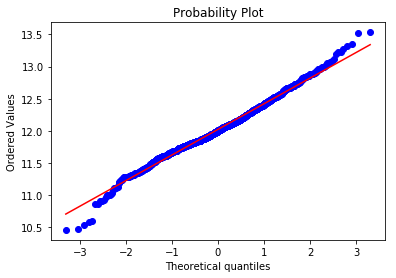

In [9]:
# Save training sales prices for future comparisons
training_sales_price = train['SalePrice']

#We use the numpy fuction log1p which  applies log(1+x) to all elements of the column
log_price_df = pd.DataFrame()
log_price_df['LogPrice'] = np.log1p(train["SalePrice"])

# Drop SalePrice and replace with Log Price
train["SalePrice"] = np.log1p(train["SalePrice"])



#Check the new distribution 
sns.distplot(train['SalePrice'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(train['SalePrice'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(train['SalePrice'], plot=plt)
plt.show()

In [10]:
ntrain = train.shape[0]
ntest = test.shape[0]
y_train = train.SalePrice.values
all_data = pd.concat((train, test)).reset_index(drop=True)
all_data.drop(['SalePrice'], axis=1, inplace=True)
print("all_data size is : {}".format(all_data.shape))

all_data size is : (2917, 79)


In [13]:
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data.head(20)

,Missing Ratio
PoolQC,99.691464
MiscFeature,96.400411
Alley,93.212204
Fence,80.425094
FireplaceQu,48.680151
LotFrontage,16.660953
GarageQual,5.450806
GarageCond,5.450806
GarageFinish,5.450806
GarageYrBlt,5.450806


Text(0.5, 1.0, 'Percent missing data by feature')

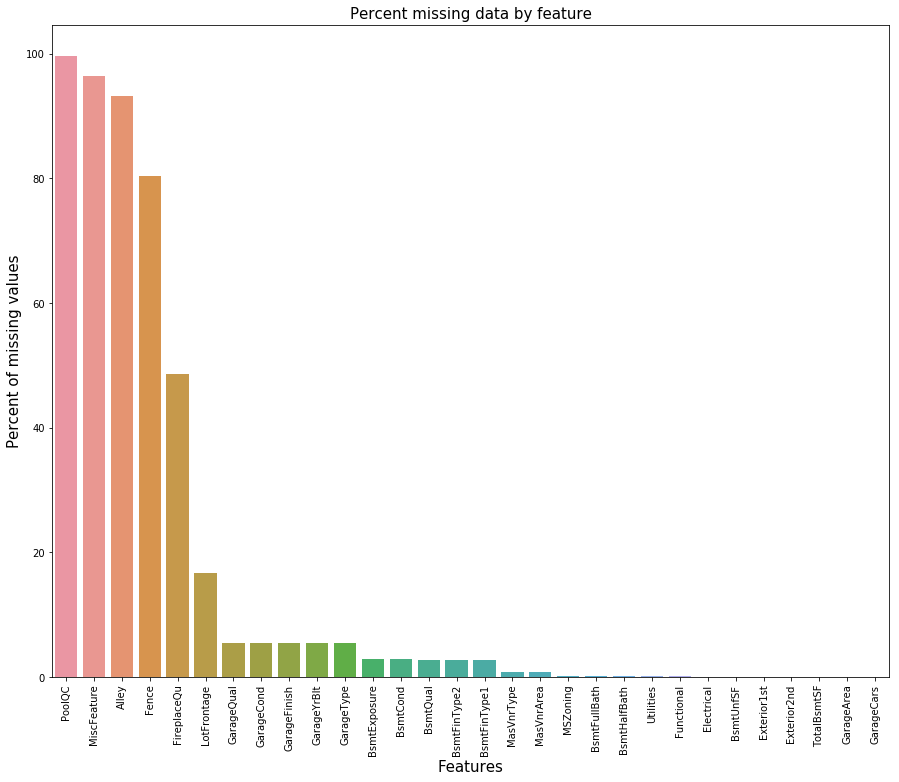

In [14]:
f, ax = plt.subplots(figsize=(15, 12))
plt.xticks(rotation='90')
sns.barplot(x=all_data_na.index, y=all_data_na)
plt.xlabel('Features', fontsize=15)
plt.ylabel('Percent of missing values', fontsize=15)
plt.title('Percent missing data by feature', fontsize=15)

In [15]:
# Fill missing Qualitative Values with 'None'

for i in ('Alley',
        'Fence',
        'FireplaceQu',
        'GarageType', 
        'GarageFinish', 
        'GarageQual', 
        'GarageCond', 
        'BsmtQual', 
        'BsmtCond', 
        'BsmtExposure', 
        'BsmtFinType1', 
        'BsmtFinType2',
        'MasVnrType',
        'MiscFeature',
        'MSSubClass',
        'PoolQC'
        ):
    all_data[i] = all_data[i].fillna('None')

In [16]:
for i in ('GarageYrBlt', 
          'GarageArea', 
          'GarageCars',
          'BsmtFinSF1', 
          'BsmtFinSF2', 
          'BsmtUnfSF',
          'TotalBsmtSF', 
          'BsmtFullBath', 
          'BsmtHalfBath',
          'MasVnrArea'
        ):
    all_data[i] = all_data[i].fillna(0)

In [17]:
# Fill in remaining variables with mode

for i in ('MSZoning', 
          'Electrical',
          'KitchenQual', 
          'Exterior1st', 
          'Exterior2nd',
          'SaleType', 
        ):
    all_data[i] = all_data[i].fillna(all_data[i].mode()[0])

In [18]:
# Fill in Functional variable with 'Typ' as suggested by other kernels

all_data['Functional'] = all_data['Functional'].fillna('Typ')

# Fill in Functional variable with the median value for its neighborhood type
all_data['LotFrontage'] = all_data.groupby('Neighborhood')['LotFrontage'].transform(
    lambda x: x.fillna(x.median()))

In [19]:
# Drop utilities column
all_data = all_data.drop(['Utilities'], axis=1)

In [20]:
#Check remaining missing values if any 
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data.head()

,Missing Ratio


In [21]:
#MSSubClass=The building class
all_data['MSSubClass'] = all_data['MSSubClass'].apply(str)


#Changing OverallCond into a categorical variable
all_data['OverallCond'] = all_data['OverallCond'].astype(str)


#Year and month sold are transformed into categorical features.
all_data['YrSold'] = all_data['YrSold'].astype(str)
all_data['MoSold'] = all_data['MoSold'].astype(str)

In [22]:
from sklearn.preprocessing import LabelEncoder
cols = ('FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond', 
        'ExterQual', 'ExterCond','HeatingQC', 'PoolQC', 'KitchenQual', 'BsmtFinType1', 
        'BsmtFinType2', 'Functional', 'Fence', 'BsmtExposure', 'GarageFinish', 'LandSlope',
        'LotShape', 'PavedDrive', 'Street', 'Alley', 'CentralAir', 'MSSubClass', 'OverallCond', 
        'YrSold', 'MoSold')
# process columns, apply LabelEncoder to categorical features
for c in cols:
    lbl = LabelEncoder() 
    lbl.fit(list(all_data[c].values)) 
    all_data[c] = lbl.transform(list(all_data[c].values))

# shape        
print('Shape all_data: {}'.format(all_data.shape))

Shape all_data: (2917, 78)


### Dealing with Skewed Features

In [23]:
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index

# Check the skew of all numerical features
skewed_feats = all_data[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness.head(10)


Skew in numerical features: 



,Skew
MiscVal,21.939672
PoolArea,17.688664
LotArea,13.109495
LowQualFinSF,12.084539
3SsnPorch,11.372080
LandSlope,4.973254
KitchenAbvGr,4.300550
BsmtFinSF2,4.144503
EnclosedPorch,4.002344
ScreenPorch,3.945101


In [24]:
skewness = skewness[abs(skewness) > 0.75]
print("There are {} skewed numerical features to Box Cox transform".format(skewness.shape[0]))

from scipy.special import boxcox1p
skewed_features = skewness.index
lam = 0.15
for feat in skewed_features:
    all_data[feat] = boxcox1p(all_data[feat], lam)

There are 58 skewed numerical features to Box Cox transform


In [25]:
all_data = pd.get_dummies(all_data)
print(all_data.shape)

(2917, 219)


In [26]:
train = all_data[:ntrain]
test = all_data[ntrain:]

## Predictions

### Linear Regression

In [27]:
lin_reg = make_pipeline(RobustScaler(), linear_model.LinearRegression())

score = rmsle_cv(lin_reg)
print("The linear regression score is: {}".format(score.mean()))
print("The linear regression standard deviation is: ({})".format(score.std()))

The linear regression score is: 0.12375719212585337
The linear regression standard deviation is: (0.010777190737041474)


### Random Forest Regression

In [28]:
rf_reg = make_pipeline(RobustScaler(), RandomForestRegressor())

score = rmsle_cv(rf_reg)
print("The RF score is: {}".format(score.mean()))
print("The RF standard deviation is: {}".format(score.std()))

C:\Users\Richard\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Richard\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Richard\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Richard\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 10

The RF score is: 0.1470835152373774
The RF standard deviation is: 0.0034105930845162373


C:\Users\Richard\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


### LASSO Regression

In [29]:
lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.0005, random_state=1))

score = rmsle_cv(lasso)
print("The Lasso score is: {}".format(score.mean()))
print("The Lasso standard deviation is: {}".format(score.std()))

The Lasso score is: 0.1125719552933337
The Lasso standard deviation is: 0.00752521549498246


### Elastic Net

In [30]:
e_net = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3))

score = rmsle_cv(e_net)
print("The elastic net regression score is: {}".format(score.mean()))
print("The elastic net regression standard deviation is: {}".format(score.std()))

The elastic net regression score is: 0.1125601913755637
The elastic net regression standard deviation is: 0.007643278836875622


### Kernel Ridge Regression

In [31]:
krr = KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)

score = rmsle_cv(krr)
print("The kernel ridge regression score is: {}".format(score.mean()))
print("The kernel ridge regression standard deviation is: {}".format(score.std()))

The kernel ridge regression score is: 0.1151345581411265
The kernel ridge regression standard deviation is: 0.007424961371129908


### Gradient Boost

In [32]:
g_boost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5)

score = rmsle_cv(g_boost)
print("The gradient boost regression score is: {}".format(score.mean()))
print("The gradient boost regression standard deviation is: {}".format(score.std()))

The gradient boost regression score is: 0.11622537169269513
The gradient boost regression standard deviation is: 0.006927538505608551


### XGBoost

In [33]:
model_xgb = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state =7, nthread = -1)

score = rmsle_cv(model_xgb)
print("The XG Boost score is: {}".format(score.mean()))
print("The XG Boost standard deviation is: {}".format(score.std()))

The XG Boost score is: 0.1164557925475399
The XG Boost standard deviation is: 0.005964352703658248


### LightGBM

In [34]:


model_lgb = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)

score = rmsle_cv(model_lgb)
print("The LGB score is: {}".format(score.mean()))
print("The LGB standard deviation is: {}".format(score.std()))



The LGB score is: 0.11503096946344893
The LGB standard deviation is: 0.007135981979708651


### Simple Stacking Model

In [35]:
class AveragingModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models):
        self.models = models
        
    # we define clones of the original models to fit the data in
    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.models]
        
        # Train cloned base models
        for model in self.models_:
            model.fit(X, y)

        return self
    
    #Now we do the predictions for cloned models and average them
    def predict(self, X):
        predictions = np.column_stack([
            model.predict(X) for model in self.models_
        ])
        return np.mean(predictions, axis=1)   

In [36]:
averaged_models = AveragingModels(models = (e_net, g_boost, krr, lasso))

score = rmsle_cv(averaged_models)
print("The averaged score is: {}".format(score.mean()))
print("The averaged standard deviation is: {}".format(score.std()))

The averaged score is: 0.10876868598237144
The averaged standard deviation is: 0.007390467789557561


### Meta Stacking Model

In [38]:
class StackingAveragedModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, base_models, meta_model, n_folds=5):
        self.base_models = base_models
        self.meta_model = meta_model
        self.n_folds = n_folds
   
    # We again fit the data on clones of the original models
    def fit(self, X, y):
        self.base_models_ = [list() for x in self.base_models]
        self.meta_model_ = clone(self.meta_model)
        kfold = KFold(n_splits=self.n_folds, shuffle=True, random_state=156)
        
        # Train cloned base models then create out-of-fold predictions
        # that are needed to train the cloned meta-model
        out_of_fold_predictions = np.zeros((X.shape[0], len(self.base_models)))
        for i, model in enumerate(self.base_models):
            for train_index, holdout_index in kfold.split(X, y):
                instance = clone(model)
                self.base_models_[i].append(instance)
                instance.fit(X[train_index], y[train_index])
                y_pred = instance.predict(X[holdout_index])
                out_of_fold_predictions[holdout_index, i] = y_pred
                
        # Now train the cloned  meta-model using the out-of-fold predictions as new feature
        self.meta_model_.fit(out_of_fold_predictions, y)
        return self
   
    #Do the predictions of all base models on the test data and use the averaged predictions as 
    #meta-features for the final prediction which is done by the meta-model
    def predict(self, X):
        meta_features = np.column_stack([
            np.column_stack([model.predict(X) for model in base_models]).mean(axis=1)
            for base_models in self.base_models_ ])
        return self.meta_model_.predict(meta_features)

In [39]:
stacked_averaged_models = StackingAveragedModels(base_models = (e_net, g_boost, krr), meta_model = lasso)

score = rmsle_cv(stacked_averaged_models)
print("The averaged score is: {}".format(score.mean()))
print("The averaged standard deviation is: {}".format(score.std()))

The averaged score is: 0.10816183088908424
The averaged standard deviation is: 0.007365727639961511


In [37]:
# define rmsle function (no cross validation)
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

### Stacked Regressor

In [40]:
stacked_averaged_models.fit(train.values, y_train)
stacked_train_pred = stacked_averaged_models.predict(train.values)
stacked_pred = np.expm1(stacked_averaged_models.predict(test.values))
print(rmsle(y_train, stacked_train_pred))

0.07920948591353263


### Adding XGBoost

In [41]:
model_xgb.fit(train, y_train)
xgb_train_pred = model_xgb.predict(train)
xgb_pred = np.expm1(model_xgb.predict(test))
print(rmsle(y_train, xgb_train_pred))

0.07978329855632173


In [42]:
model_lgb.fit(train, y_train)
lgb_train_pred = model_lgb.predict(train)
lgb_pred = np.expm1(model_lgb.predict(test.values))
print(rmsle(y_train, lgb_train_pred))

0.07225855235146215


### Testing the Stacked Model against the entire Training Set

In [43]:
print('RMSLE score on train data:')
print(rmsle(y_train,stacked_train_pred*0.69 +
               xgb_train_pred*0.16 + lgb_train_pred*0.15 ))

RMSLE score on train data:
0.07606989334147128


In [44]:
ensemble = stacked_pred*0.69 + xgb_pred*0.16 + lgb_pred*0.15

### Submission

In [45]:
sub = pd.DataFrame()
sub['Id'] = test_ID
sub['SalePrice'] = ensemble
sub.to_csv('submission.csv',index=False)